<a href="https://colab.research.google.com/github/huyhoang1996vn/my-ml/blob/master/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [5]:
df = pd.read_csv('bank-marketing.csv', sep=';')
display(df.head())
df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,14770.000000,14770.000000,14770.000000,14770.0,14770.0,14770.000000,14770.000000,14769.000000,14769.000000,14769.000000
mean,39.809005,259.590183,2.769939,999.0,0.0,1.242322,94.119872,-39.121999,4.898086,5208.599201
std,9.071186,256.377464,3.150074,0.0,0.0,0.149808,0.225726,2.881065,0.049866,18.526244
min,20.000000,0.000000,1.000000,999.0,0.0,1.100000,93.000000,-42.700000,4.855000,5191.000000
25%,33.000000,107.000000,1.000000,999.0,0.0,1.100000,93.994000,-41.800000,4.857000,5191.000000
50%,39.000000,184.000000,2.000000,999.0,0.0,1.100000,93.994000,-36.400000,4.864000,5191.000000
75%,46.000000,321.000000,3.000000,999.0,0.0,1.400000,94.465000,-36.400000,4.960000,5228.100000
max,61.000000,3643.000000,56.000000,999.0,0.0,1.400000,94.465000,-36.400000,4.967000,5228.100000


In [6]:
df_features = df.drop('y', axis=1)
df_target = df['y']


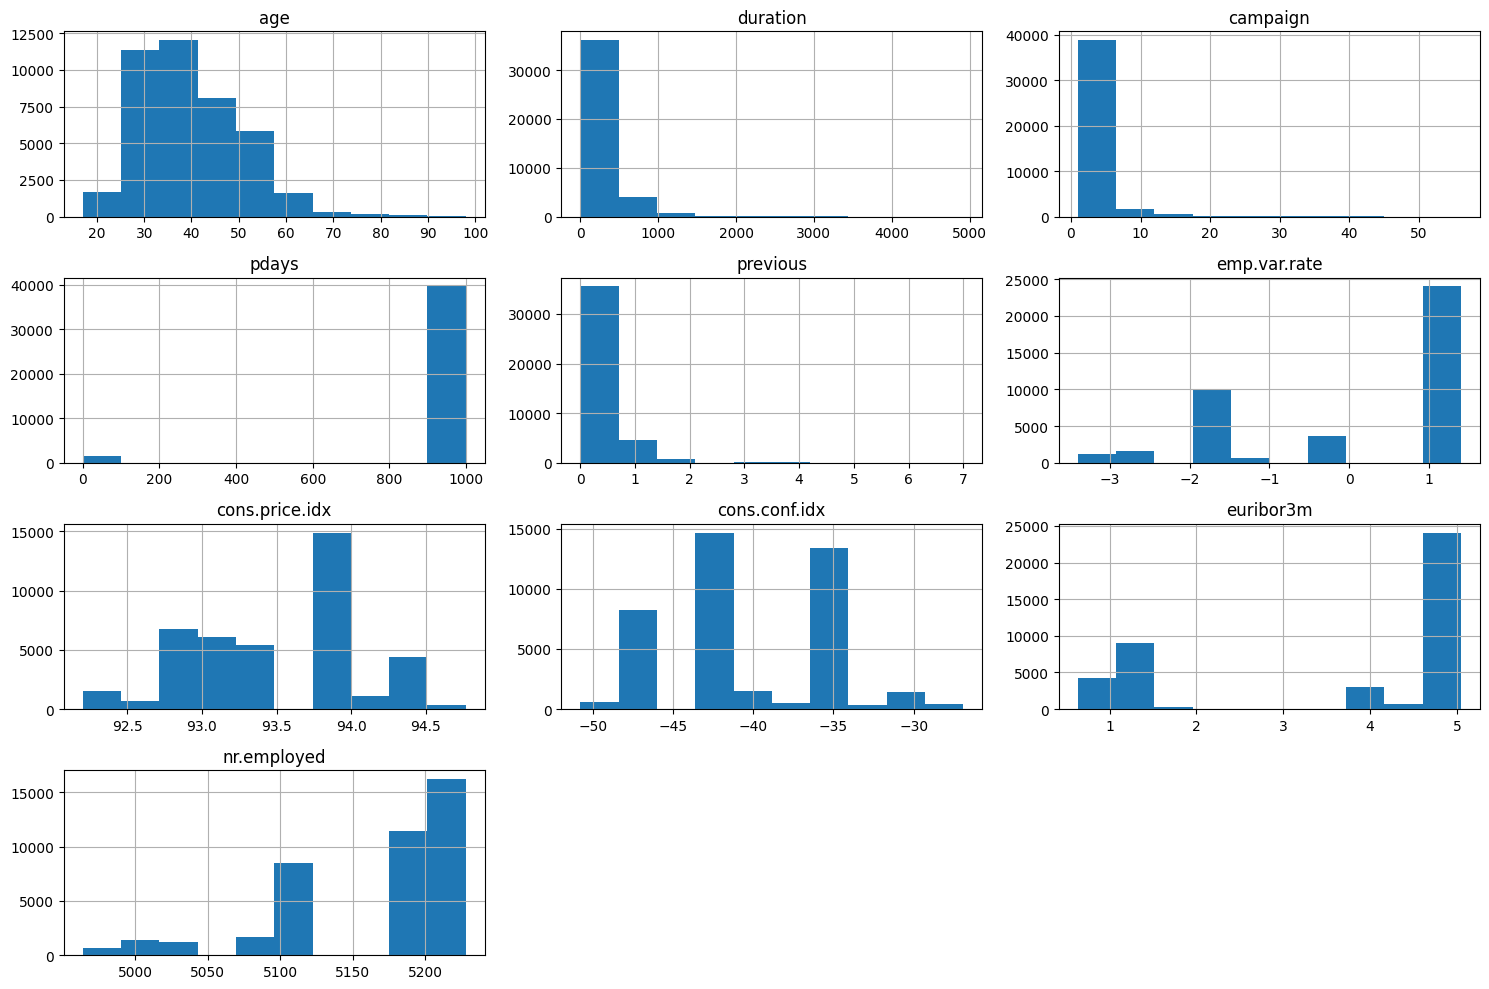

In [12]:
import matplotlib.pyplot as plt

df_features.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

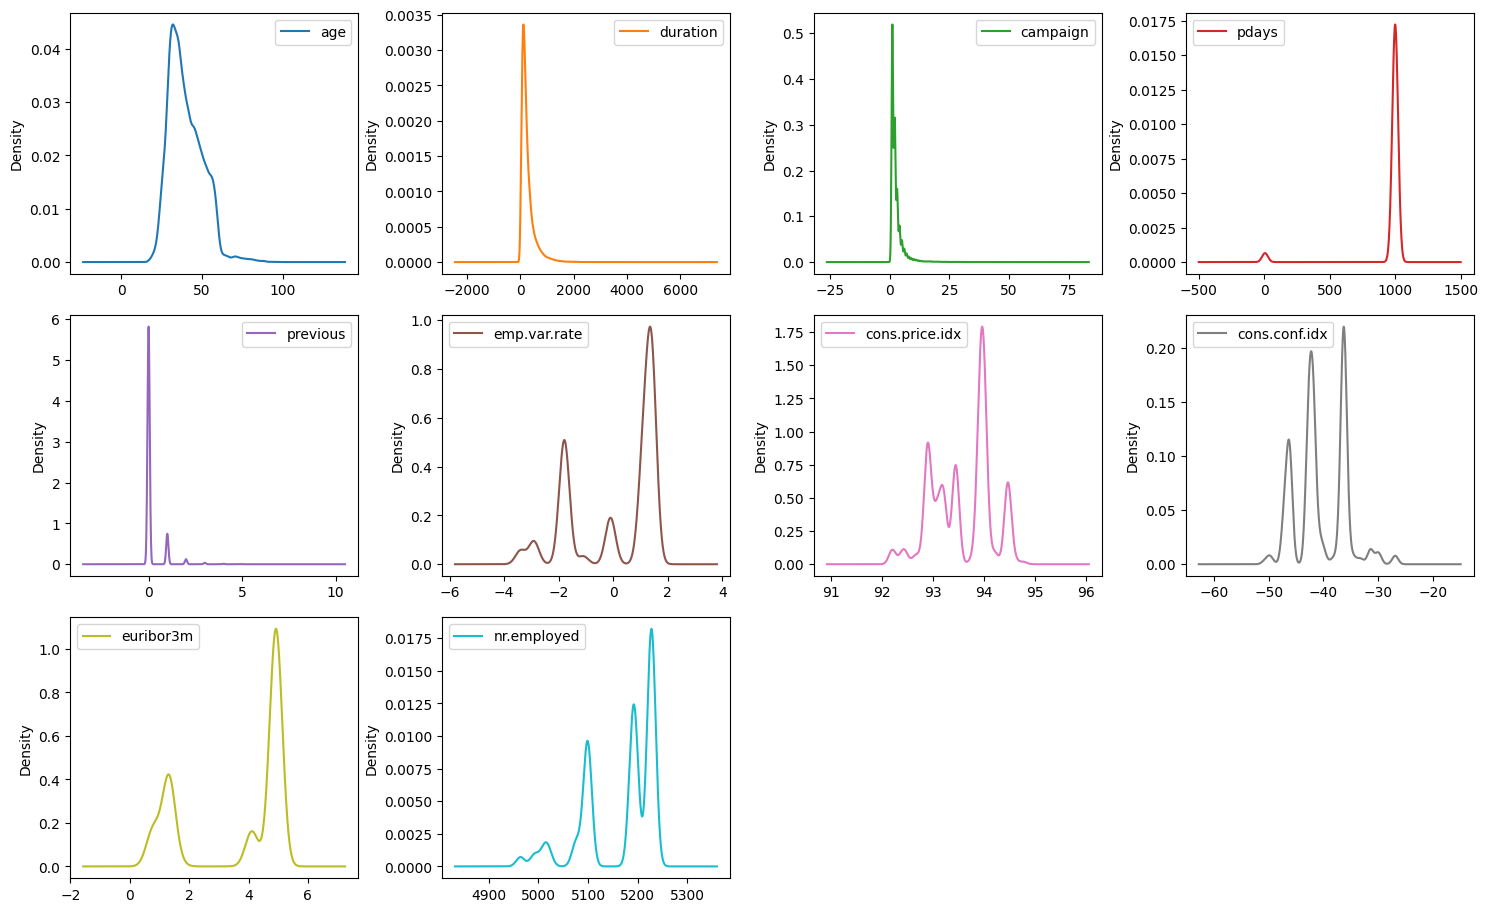

In [13]:
import matplotlib.pyplot as plt

df_features.plot(kind='density', subplots=True, layout=(5, 4), figsize=(15, 15), sharex=False)
plt.tight_layout()
plt.show()

In [15]:
print(df_features.dtypes)

age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome             object
emp.var.rate        float64
cons.price.idx      float64
cons.conf.idx       float64
euribor3m           float64
nr.employed         float64
job_hashed            int64
education_hashed      int64
marital_ordinal       int64
dtype: object


In [14]:
import hashlib

def hash_encode(value):
    if isinstance(value, str):
        return int(hashlib.sha256(value.encode('utf-8')).hexdigest(), 16) % (2**10) # Using a modulo for a smaller integer range
    return value

df_features['job_hashed'] = df_features['job'].apply(hash_encode)
df_features['education_hashed'] = df_features['education'].apply(hash_encode)

display(df_features.head())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_hashed,education_hashed,marital_ordinal
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,786,535,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,589,445,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,589,445,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,103,211,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,589,445,1


In [19]:
display(df_features['default'].value_counts())

,count
default,
no,10286
unknown,4484


In [20]:
marital_mapping = {'single': 0, 'married': 1, 'divorced': 2, 'unknown': 3}
df_features['marital_ordinal'] = df_features['marital'].map(marital_mapping)
marital_mapping = {'no': 0, 'unknown': 1}
df_features['default_ordinal'] = df_features['default'].map(marital_mapping)
display(df_features[['marital', 'marital_ordinal', 'default', 'default_ordinal']].head())

,marital,marital_ordinal,default,default_ordinal
0,married,1,no,0
1,married,1,unknown,1
2,married,1,no,0
3,married,1,no,0
4,married,1,no,0


In [24]:
df_features_cleaned = df_features[['age','default_ordinal','cons.price.idx','cons.conf.idx', 'marital_ordinal', 'job_hashed', 'education_hashed']]
df_features_cleaned.head()
correlation_matrix = df_features_cleaned.corr()
display(correlation_matrix)

,age,default_ordinal,cons.price.idx,cons.conf.idx,marital_ordinal,job_hashed,education_hashed
age,1.000000,0.226974,0.047587,0.070439,0.334786,0.004141,0.036141
default_ordinal,0.226974,1.000000,0.019264,0.032781,0.046430,0.185062,-0.090055
cons.price.idx,0.047587,0.019264,1.000000,-0.500332,0.020466,0.002266,0.007946
cons.conf.idx,0.070439,0.032781,-0.500332,1.000000,0.031757,0.003132,-0.009576
marital_ordinal,0.334786,0.046430,0.020466,0.031757,1.000000,0.062541,-0.055888
job_hashed,0.004141,0.185062,0.002266,0.003132,0.062541,1.000000,-0.334947
education_hashed,0.036141,-0.090055,0.007946,-0.009576,-0.055888,-0.334947,1.000000


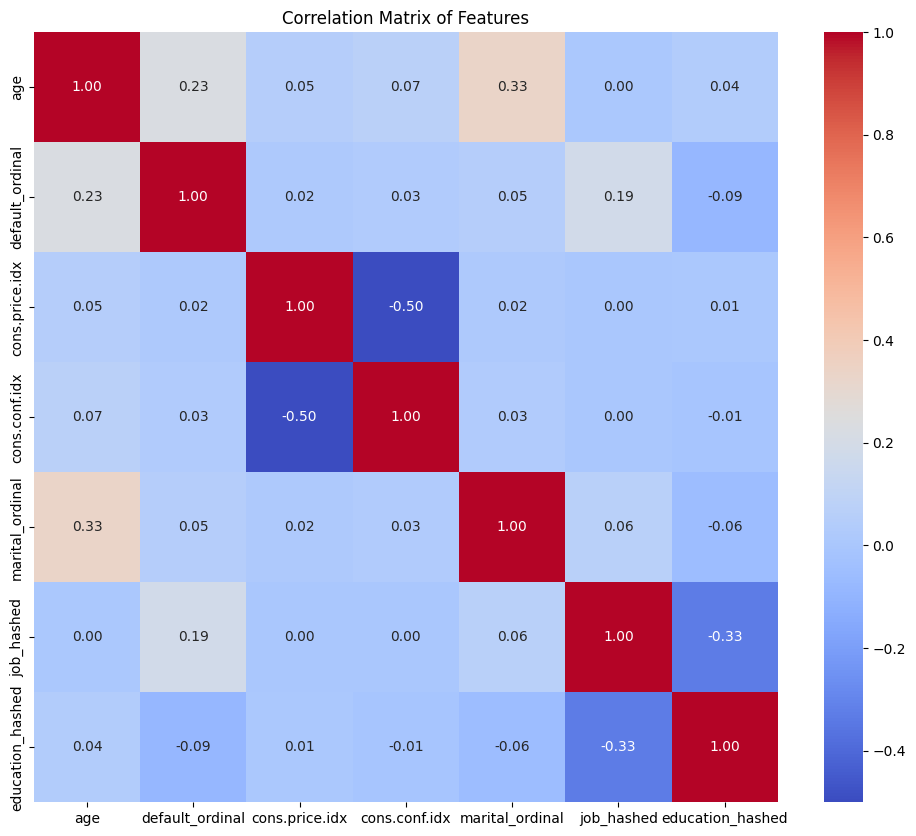

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [29]:
# Identify pairs of features with high collinearity
high_collinearity_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_collinearity_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

if high_collinearity_pairs:
    print("Pairs of features with high collinearity (absolute correlation > 0.7):")
    for feature1, feature2, correlation_value in high_collinearity_pairs:
        print(f"- {feature1} and {feature2}: {correlation_value:.2f}")
else:
    print("No pairs of features with high collinearity (absolute correlation > 0.7) found.")

No pairs of features with high collinearity (absolute correlation > 0.7) found.


In [ ]:
df_features_cleaned

In [32]:
print("Missing values in features:")
print(df_features_cleaned.isnull().sum())

print("\nMissing values in target:")
print(df_target.isnull().sum())

Missing values in features:
age                 0
default_ordinal     0
cons.price.idx      0
cons.conf.idx       1
marital_ordinal     0
job_hashed          0
education_hashed    0
dtype: int64

Missing values in target:
1


In [33]:
df_features_cleaned = df_features_cleaned.dropna()
df_target = df_target.dropna()

# Verify that missing values have been removed
print("Missing values in features after dropping:")
print(df_features_cleaned.isnull().sum())

print("\nMissing values in target after dropping:")
print(df_target.isnull().sum())

Missing values in features after dropping:
age                 0
default_ordinal     0
cons.price.idx      0
cons.conf.idx       0
marital_ordinal     0
job_hashed          0
education_hashed    0
dtype: int64

Missing values in target after dropping:
0


In [46]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(df_features_cleaned, df_target, test_size=0.2)


In [47]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(features_train, target_train)

RandomForestClassifier()

In [48]:
target_pred = random_forest_model.predict(features_test)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(target_test, target_pred)
precision = precision_score(target_test, target_pred, pos_label='yes')
recall = recall_score(target_test, target_pred, pos_label='yes')
f1 = f1_score(target_test, target_pred, pos_label='yes')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.07
Recall: 0.01
F1-score: 0.02


In [50]:
display(df_target.value_counts())

,count
y,
no,14184
yes,585


In [51]:
!pip install imblearn

In [57]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
features_train_oversampled, target_train_oversampled = ros.fit_resample(features_train, target_train)

print("Original training set shape:", features_train.shape)
print("Oversampled training set shape:", features_train_oversampled.shape)
print("\nOriginal training target distribution:\n", target_train.value_counts())
print("\nOversampled training target distribution:\n", target_train_oversampled.value_counts())

Original training set shape: (11815, 7)
Oversampled training set shape: (22732, 7)

Original training target distribution:
 y
no     11366
yes      449
Name: count, dtype: int64

Oversampled training target distribution:
 y
no     11366
yes    11366
Name: count, dtype: int64


In [56]:
random_forest_model_oversampled = RandomForestClassifier()
random_forest_model_oversampled.fit(features_train_oversampled, target_train_oversampled)

target_pred_oversampled = random_forest_model_oversampled.predict(features_test)

accuracy_oversampled = accuracy_score(target_test, target_pred_oversampled)
precision_oversampled = precision_score(target_test, target_pred_oversampled, pos_label='yes')
recall_oversampled = recall_score(target_test, target_pred_oversampled, pos_label='yes')
f1_oversampled = f1_score(target_test, target_pred_oversampled, pos_label='yes')

print(f"Accuracy (Oversampled): {accuracy_oversampled:.2f}")
print(f"Precision (Oversampled): {precision_oversampled:.2f}")
print(f"Recall (Oversampled): {recall_oversampled:.2f}")
print(f"F1-score (Oversampled): {f1_oversampled:.2f}")

Accuracy (Oversampled): 0.85
Precision (Oversampled): 0.06
Recall (Oversampled): 0.16
F1-score (Oversampled): 0.09
